In [14]:
import pandas as pd
import dask.dataframe as dd
from pathlib import Path
from bs4 import BeautifulSoup
import re

Lets Start by loading and looking at out first Dataset, found in the flight_header.csv

The github repository this dataset was placed in already tells us a lot of information about each column
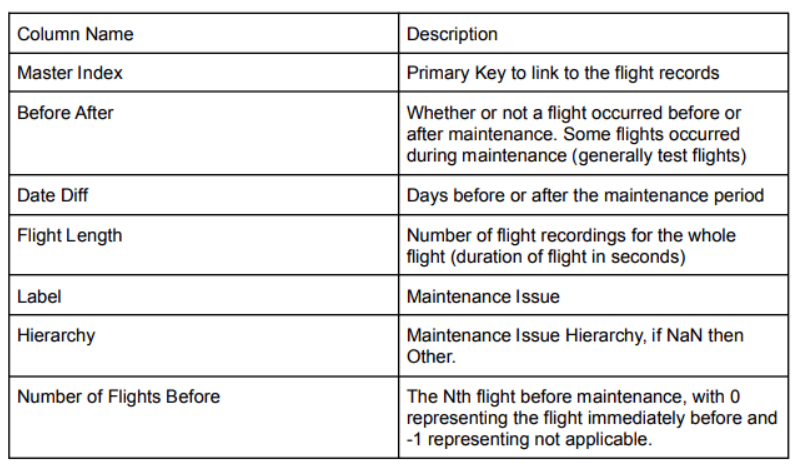

In [5]:
# Flight Header df
project_dir = Path.cwd().parent
flight_header_path = project_dir / "data" / "all_flights" / "all_flights" / "flight_header.csv"
assert flight_header_path.exists()

flight_header_df = pd.read_csv(flight_header_path, index_col="Master Index")
flight_header_df.head()

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before
Master Index,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0
2,before,-2,4649.0,intake gasket leak/damage,NaN,3
3,same,0,40.0,intake gasket leak/damage,NaN,-1
4,before,0,14.0,intake gasket leak/damage,NaN,0
5,same,0,683.0,intake gasket leak/damage,NaN,-1


In [11]:
flight_header_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28935 entries, 1 to 32820
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   before_after           28935 non-null  object 
 1   date_diff              28935 non-null  int64  
 2   flight_length          28935 non-null  float64
 3   label                  28935 non-null  object 
 4   hierarchy              10581 non-null  object 
 5   number_flights_before  28935 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.5+ MB


We have 28935 rows of data, with 6 columns. 

All of our columns are fully populated except the hierarchy column, which has 18,354 null records. Since this column represents the maintance issue hierarchy, we can leave as is for now since we don't plan on doing anything with that column just yet.

We are expecting int64 or float64 type for our "date_diff", "flight_length", and "number_flights_before" columns

In [12]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before
count,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445
std,3.721469,3065.589572,1.634050
min,-108.000000,12.000000,-1.000000
25%,-1.000000,419.000000,-1.000000
50%,0.000000,4402.000000,-1.000000
75%,1.000000,5771.000000,1.000000
max,70.000000,30059.000000,4.000000


Nothing looks out of place for our statistical analysis of the data

Lets look at the object type column that we care about, 'label' column

In [13]:
flight_header_df["label"].unique()

array(['intake gasket leak/damage', 'engine need repair/reinstall/clean',
       'engine run rough', 'baffle plug need repair/replace',
       'baffle bracket loose/damage', 'rocker cover leak/loose/damage',
       'oil cooler need maintenance', 'engine failure/fire/time out',
       'baffle screw miss/loose', 'pilot/in-flight noticed issue',
       'aircraft start/external issue', 'cowling miss/loose/damage',
       'engine/propeller overspeed or damage',
       'engine seal/tube/bolt loose or damage',
       'cylinder crack/fail/need part repair',
       'baffle tie/tie rod loose or damage', 'oil leak/pressure issue',
       'drain line/tube damage', 'baffle mount loose/damage',
       'baffle spring damage', 'cylinder compression issue',
       'intake tube/bolt/seal/boot loose or damage',
       'engine idle/rpm issue',
       'engine crankcase/crankshaft/firewall near repair',
       'oil dipstick/tube need repair', 'oil return line issue',
       'mixture fail/need adjust', 'spar

Many of these labels for maintanance issues have similar aircraft part associated with them, so we can categorize them into part_name categories to make our analysis easier. We will create a dictionary of rules of regex patterns to find in each label, and categorize it based on the associated part name.

In [16]:
Rules = [
    ("baffle kit", r"\bbaffle\s*(seal|crack|spring|mount|tie|bracket)\b"),
    ("baffle screw", r"\bbaffle\s*screw\b"),
    ("baffle plug", r"\bbaffle\s*plug\b"),
    ("baffle rivet ", r"\bbaffle\s*rivet \b"),
    ("intake gasket", r"\bintake\s*gasket\b"),
    ("intake tube/bolt/seal/boot", r"\bintake\s*(tube|bolt|seal|boot)\b"),
    ("engine", r"\bengine\b"),
    ("rocker cover", r"\brocker\s*cover\b"),
    ("oil cooler", r"\boil\s*cooler\b"),
    ("oil pressure", r"\boil\s*(leak|pressure)\b"),
    ("oil dipstick", r"\boil\s*(dipstick|return)\b"),
    ("cowling", r"\bcowling\b"),
    ("cylinder", r"\bcylinder\b"),
    ("drain line/tube", r"\bdrain\s*(line|tube)\b"),
    ("mixture", r"\bmixture\b"),
    ("spark plug", r"\bspark\s*plug\b"),
    ("magneto", r"\bmagneto\b"),
    ("induction", r"\binduction\b"),
    ("other", r".*")
]

def categorize_part(name):
    for part_name, pattern in Rules:
        if re.search(pattern, name, re.IGNORECASE):
            return part_name
    return "other"

flight_header_df["partName"] = flight_header_df["label"].apply(categorize_part)
flight_header_df["partName"].value_counts()


partName
intake gasket                 10140
rocker cover                   5219
baffle kit                     3191
engine                         2959
cylinder                       1578
intake tube/bolt/seal/boot     1372
baffle plug                    1142
baffle screw                    894
other                           831
oil cooler                      312
drain line/tube                 228
baffle rivet                    224
cowling                         211
oil dipstick                    151
magneto                         141
induction                       133
oil pressure                    130
mixture                          40
spark plug                       39
Name: count, dtype: int64

This is much better to look at and analyze, here we can see that intake gaskets are the aircraft part that needs the most maintanance. 

Before we look at the second dataset connected to the flight_header_df, we want to include the price it takes to replace each of the partNames above. Unfortunately, this dataset doesn't provide prices, and it was difficult to find any other existing dataset out there that does. This can be bacause prices are always changing, and can vary from one producer/aircraft type to another.

For our analysis, we have found an online aircraft parts supplier, https://www.chiefaircraft.com/aircraft.html and grabbed the prices they have on their website as of November 11th, 2025. 

Note: The price of "other" was calculated by taking the average of all the other prices

In [ ]:
prices_dict = {
    "partName": ["baffle kit", "baffle screw", "baffle plug", "baffle rivet ", "intake gasket",
                 "intake tube/bolt/seal/boot", "engine", "rocker cover", "oil cooler", "oil pressure",
                 "oil dipstick", "cowling", "cylinder", "drain line/tube", "mixture",
                 "spark plug", "magneto", "induction", "other"],
    "priceUSD": [419.95, 6.95, 39.95, 24.50, 4.50, 
                 16.50, 839.99, 11.25, 1189.00, 265.00, 
                 8.50, 1190.00, 795.00, 19.95, 215.95, 
                 44.00, 859.00, 169.00, 305.95]

}

prices = pd.DataFrame(prices_dict)

Now lets adds the prices to the main flight_header_df by merging based on partName

In [25]:
flight_header_df = flight_header_df.merge(prices, on="partName", how="left")

In [26]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before,priceUSD
count,28935.000000,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445,218.936975
std,3.721469,3065.589572,1.634050,332.606137
min,-108.000000,12.000000,-1.000000,4.500000
25%,-1.000000,419.000000,-1.000000,4.500000
50%,0.000000,4402.000000,-1.000000,11.250000
75%,1.000000,5771.000000,1.000000,419.950000
max,70.000000,30059.000000,4.000000,1190.000000


In [ ]:
flight_header_df.loc[flight_header_df["partName"]== "other", :]

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,partName,priceUSD
14672,before,0,450.0,pilot/in-flight noticed issue,NaN,0,other,305.95
14673,after,2,4932.0,pilot/in-flight noticed issue,NaN,-1,other,305.95
14674,before,0,3216.0,pilot/in-flight noticed issue,NaN,0,other,305.95
14675,after,2,3827.0,pilot/in-flight noticed issue,NaN,-1,other,305.95
14676,same,0,3200.0,pilot/in-flight noticed issue,NaN,-1,other,305.95
...,...,...,...,...,...,...,...,...
15498,after,1,4464.0,aircraft start/external issue,NaN,-1,other,305.95
15499,before,-1,45.0,aircraft start/external issue,NaN,3,other,305.95
15500,before,-63,294.0,aircraft start/external issue,NaN,2,other,305.95
15501,same,0,10815.0,aircraft start/external issue,NaN,-1,other,305.95


The partName labeled "other" is mainly for the labels "aircraft start/external issue" and "pilot/in-flight noticed issue" which don't specify a part as the issue

Now its time to look at the other dataset connected to flight_header_df, the github repo also tells us about the meaning of each column
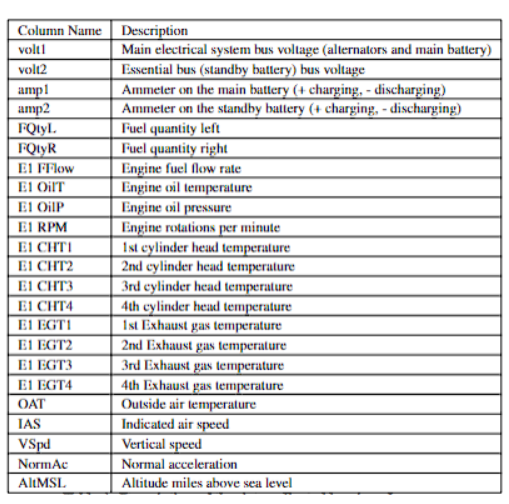


Voltages: volt1, volt2

Amperages: amp1, amp2

Fuel metrics: FQtyL, FQtyR, FFflow

Engine metrics: RPM, OilP, OilT

Temperatures: CHT1–CHT4, EGT1–EGT4

Flight metrics: IAS, VSpd, NormAc

Altitude: AltMSL

Outside Air Temp: OAT

In [28]:
# Flight Data df
flight_data_path = project_dir / "data" / "all_flights" / "all_flights" / "one_parq"
assert flight_data_path.exists()

flight_data_df = dd.read_parquet(flight_data_path)
flight_data_df.head()


,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
Master Index,,,,,,,,,,,,,,,,,,,,,
1,28.8,NaN,0.8,NaN,48.89,44.06,13.28,168.55,82.51,2519.7,...,1317.44,1298.97,1322.83,12.8,144.89,29.61,0.01,3010.7,3151,c_28
1,28.8,NaN,0.8,NaN,48.93,44.06,13.31,168.60,82.51,2519.4,...,1316.64,1300.68,1322.15,12.8,144.53,49.78,-0.00,3011.3,3150,c_28
1,28.8,NaN,0.9,NaN,48.96,44.06,13.36,168.65,82.51,2520.3,...,1317.20,1301.05,1323.12,12.8,144.15,58.68,-0.01,3011.8,3149,c_28
1,28.8,NaN,0.7,NaN,48.86,44.06,13.30,168.64,82.51,2519.3,...,1317.73,1302.14,1321.93,12.8,143.79,47.31,-0.00,3012.2,3148,c_28
1,28.8,NaN,0.6,NaN,48.87,44.06,13.30,168.65,82.51,2518.8,...,1318.00,1308.52,1316.99,12.8,143.45,36.05,-0.01,3012.3,3147,c_28


In [9]:
flight_data_df.columns

Index(['volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow',
       'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3',
       'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS',
       'VSpd', 'NormAc', 'AltMSL', 'timestep', 'cluster'],
      dtype='object')